# Initial data exploration
The goal of this notebook is to provide a quick overview of the competition and to create an idea of the objective solution, data and metrics.

Some tl;dr items to note:
- The accuracy competition will use the metric: **Weighted Root Mean Squared Scaled Error** (RMSSE)
- We are tasked with forecasting hierarchical sales data from Wal-Mart.
- The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details.
- In addition, it has explanatory variables such as price, promotions, day of the week, and special events.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Data Files
- `calendar.csv` - Contains information about the dates on which the products are sold.
- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
- `sample_submission.csv` - The correct format for submissions. Reference the Evaluation tab for more info.
- `sell_prices.csv` - Contains information about the price of the products sold per store and date.

Not available yet:
- `sales_train_evaluation.csv` - Available one month before competition deadline. Will include sales [d_1 - d_1941]

In [2]:
# Read in the data
cal = pd.read_csv('data/calendar.csv')
stv = pd.read_csv('data/sales_train_validation.csv')
ss = pd.read_csv(f'data/sample_submission.csv')
sellp = pd.read_csv('data/sell_prices.csv')

# Understanding the Data

The dataset involves the unit sales of various products sold in the USA, organized in the form of grouped time series. More specifically, the dataset involves the unit sales of 3,049 products, classified in 3 product categories (Hobbies, Foods, and Household) and 7 product departments, in which the above-mentioned categories are disaggregated.  The products are sold across ten stores, located in three States (CA, TX, and WI)

| Level ID | Aggregation Level                                                      | Number of series |
|----------|------------------------------------------------------------------------|------------------|
| 1        | Unit sales of all products, aggregated for all   stores/states         | 1                |
| 2        | Unit sales of all products, aggregated for each   State                | 3                |
| 3        | Unit sales of all products, aggregated for each   store                | 10               |
| 4        | Unit sales of all products, aggregated for each   category             | 3                |
| 5        | Unit sales of all products, aggregated for each   department           | 7                |
| 6        | Unit sales of all products, aggregated for each   State and category   | 9                |
| 7        | Unit sales of all products, aggregated for each   State and department | 21               |
| 8        | Unit sales of all products, aggregated for each   store and category   | 30               |
| 9        | Unit sales of all products, aggregated for each   store and department | 70               |
| 10       | Unit sales of product x, aggregated for all stores/states              | 9.149            |
| 11       | Unit sales of product x, aggregated for each State                     | 9.147           |
| 12       | Unit sales of product x, aggregated for each store                     | 30.490           |
| -        | **Total**                                                              | **42.840**       |

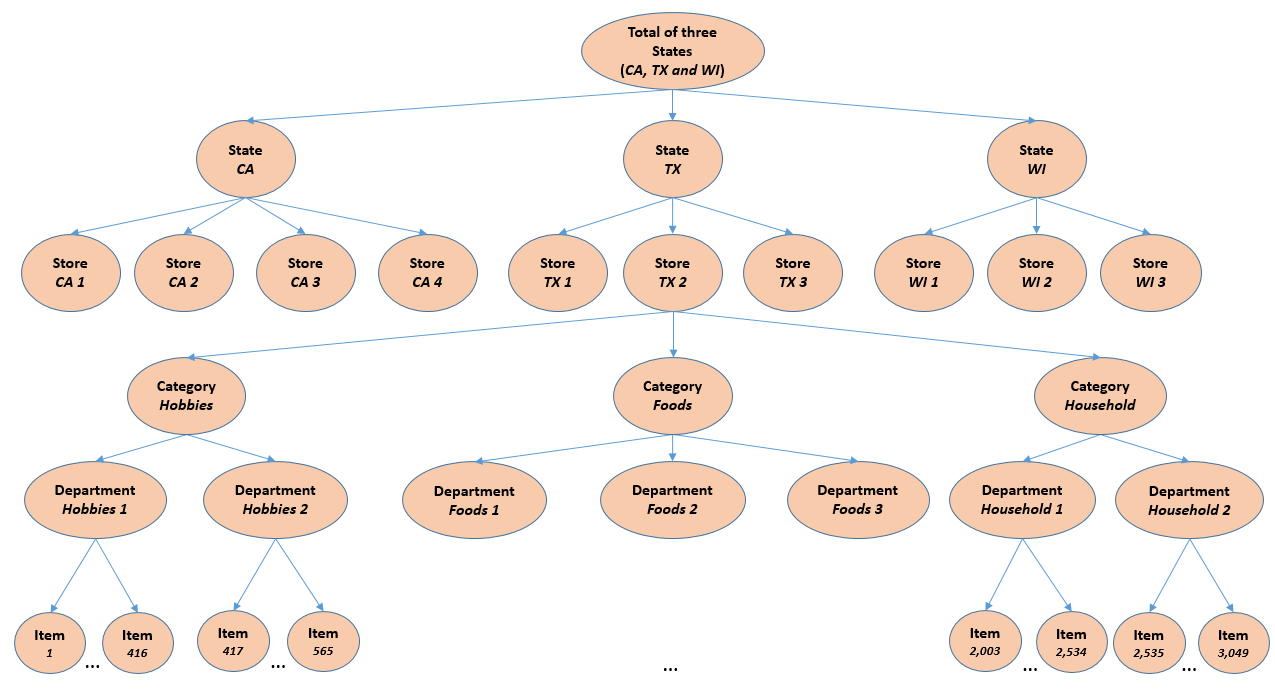

In [7]:
from IPython.display import Image
Image("img/datagram.png")

The historical data range from 2011-01-29 to 2016-06-19. Thus, the products have a (maximum) selling history of **1,941<sup>2</sup>  days / 5.4 years** (test data of h=28 days not included). 

The dataset consists of the following three (3) files:

## File 1: “calendar.csv” 

In [17]:
cal.sample(5)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
609,2012-09-29,11236,Saturday,1,9,2012,d_610,NaN,NaN,NaN,NaN,0,0,0
1397,2014-11-26,11443,Wednesday,5,11,2014,d_1398,NaN,NaN,NaN,NaN,0,0,0
134,2011-06-12,11120,Sunday,2,6,2011,d_135,NBAFinalsEnd,Sporting,NaN,NaN,0,1,1
759,2013-02-26,11305,Tuesday,4,2,2013,d_760,NaN,NaN,NaN,NaN,0,0,0
1890,2016-04-02,11610,Saturday,1,4,2016,d_1891,NaN,NaN,NaN,NaN,1,0,1


Contains information about the dates the products are sold.
*	**date:** The date in a “y-m-d” format.
*	**wm_yr_wk:** The id of the week the date belongs to.
*	**weekday:** The type of the day (Saturday, Sunday, …, Friday).
*	**wday:** The id of the weekday, starting from Saturday.
*	**month:** The month of the date.
*	**year:** The year of the date.
*	**event_name_1:** If the date includes an event, the name of this event.
*	**event_type_1:** If the date includes an event, the type of this event.
*	**event_name_2:** If the date includes a second event, the name of this event.
*	**event_type_2:** If the date includes a second event, the type of this event.
*	**snap_CA, snap_TX, and snap_WI:** A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP  purchases on the examined date. 1 indicates that SNAP purchases are allowed.


## File 2: “sell_prices.csv”

In [11]:
sellp.sample(5)

,store_id,item_id,wm_yr_wk,sell_price
5572665,WI_2,HOBBIES_2_047,11445,0.50
3177409,TX_1,FOODS_2_210,11425,3.74
2934703,TX_1,HOUSEHOLD_1_448,11537,0.96
4036875,TX_2,FOODS_3_497,11407,2.50
6472569,WI_3,HOUSEHOLD_2_347,11620,8.94


Contains information about the price of the products sold per store and date.
*	**store_id:** The id of the store where the product is sold. 
*	**item_id:** The id of the product.
*	**wm_yr_wk:** The id of the week.
*	**sell_price:** The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).  


## File 3: “sales_train_validation.csv” 

In [16]:
stv.sample(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
2722,FOODS_3_498_CA_1_validation,FOODS_3_498,FOODS_3,FOODS,CA_1,CA,11,27,6,12,10,28,12,26,16,7,18,19,24,32,10,29,14,5,4,...,64,0,0,0,2,0,0,0,4,6,18,8,2,0,9,5,4,0,10,8,6,4,1,14,5
28861,HOUSEHOLD_2_325_WI_3_validation,HOUSEHOLD_2_325,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1,3,3,0,0,0,1,0,1,0,0,0,0,1,1,1,0,0,0,...,0,0,1,0,0,0,1,1,0,2,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
24916,HOBBIES_2_109_WI_2_validation,HOBBIES_2_109,HOBBIES_2,HOBBIES,WI_2,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0
1139,HOUSEHOLD_2_043_CA_1_validation,HOUSEHOLD_2_043,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1,0,0,1,1,0,0,0,1,1,0,1,2,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0,1,0,1,2,1,1,0,0,0,0,1,0,1,0,1
887,HOUSEHOLD_1_329_CA_1_validation,HOUSEHOLD_1_329,HOUSEHOLD_1,HOUSEHOLD,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,2,2,1,0,0,2,1,3,0,1,3,0,1,0,1,1,1,2,4,1,2


Contains the historical daily unit sales data per product and store.

*	**item_id:** The id of the product.
*	**dept_id:** The id of the department the product belongs to.
*	**cat_id:** The id of the category the product belongs to.
*	**store_id:** The id of the store where the product is sold.
*	**state_id:** The State where the store is located.
*	**d_1, d_2, …, d_i, … d_1913:** The number of units sold at day i, starting from 2011-01-29. 

- rows exist in this dataset for days d_1 to d_1913. We are given the department, category, state, and store id of the item.
- d_1914 - d_1941 represents the `validation` rows which we will predict in stage 1
- d_1942 - d_1969 represents the `evaluation` rows which we will predict for the final competition standings.

# What exactly are we trying to predict?
We are trying for forecast sales for 28 forecast days. The sample submission has the following format:
- The columns represent 28 forecast days. We will fill these forecast days with our predictions.
- The rows each represent a specific item. This id tells us the item type, state, and store. We don't know what these items are exactly.

In [5]:
ss.sample(5)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
19761,HOUSEHOLD_2_372_TX_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26833,FOODS_3_217_WI_2_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15018,FOODS_3_598_TX_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49663,HOUSEHOLD_1_321_TX_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29659,FOODS_2_392_WI_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Visualizing the data for a single item
- Lets take a random item that sell a lot and see how it's sales look across the training data.
- `FOODS_3_090_CA_3_validation` sells a lot
- Note there are days where it appears the item is unavailable and sales flatline

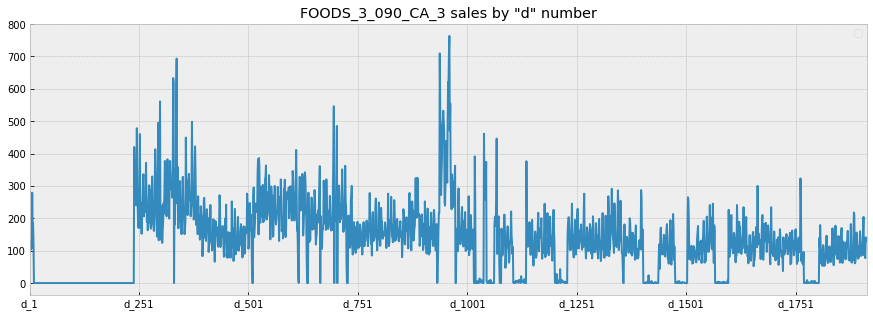

In [59]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

## Merging the data with real dates
- We are given a calendar with additional information about past and future dates.
- The calendar data can be merged with our days data
- From this we can find weekly and annual trends

In [60]:
# Calendar data looks like this (only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].sample(5)

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
285,d_286,2011-11-10,NaN,NaN,NaN,NaN,1
484,d_485,2012-05-27,NaN,NaN,NaN,NaN,0
1880,d_1881,2016-03-23,NaN,NaN,NaN,NaN,0
258,d_259,2011-10-14,NaN,NaN,NaN,NaN,0
1281,d_1282,2014-08-02,NaN,NaN,NaN,NaN,1


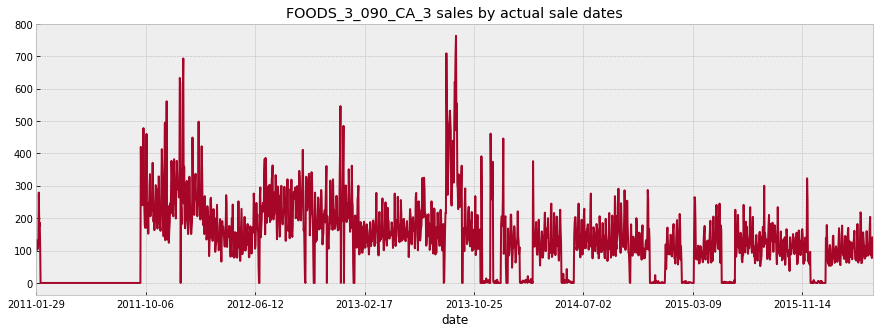

In [61]:
# Merge calendar on our items' data
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

# Select more top selling examples
example2 = stv.loc[stv['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) # Name it correctly
example2 = example2.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example2 = example2.merge(cal, how='left', validate='1:1')

example3 = stv.loc[stv['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example3 = example3.merge(cal, how='left', validate='1:1')

# Sales broken down by time variables
- Now that we have our example item lets see how it sells by:
    - Day of the week
    - Month
    - Year

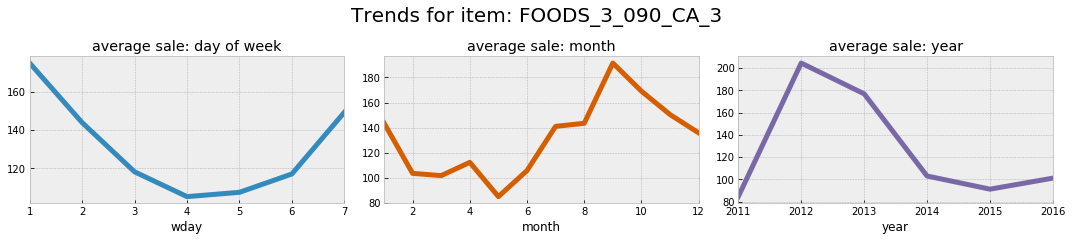

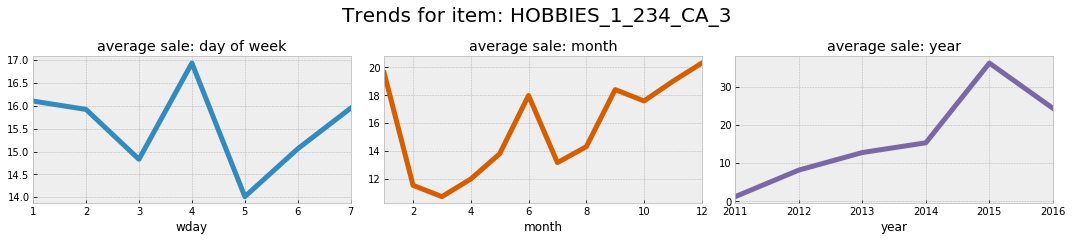

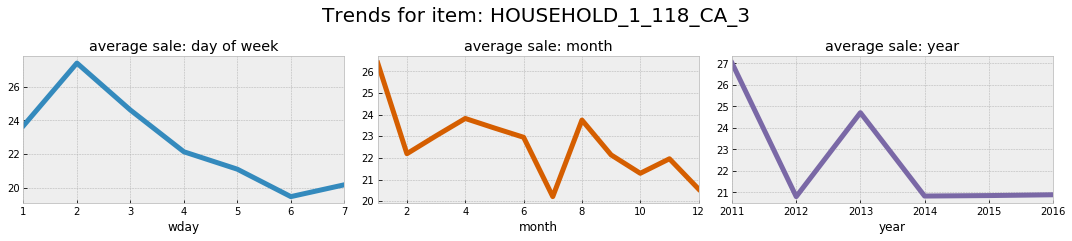

In [62]:
examples = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3','HOUSEHOLD_1_118_CA_3']
example_df = [example, example2, example3]
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    example_df[i].groupby('wday').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],

              ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],

              ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()

# Lets look at a lot of different items!
- Lets put it all together to plot 20 different items and their sales
- Some observations from these plots:
    - It is common to see an item unavailable for a period of time.
    - Some items only sell 1 or less in a day, making it very hard to predict.
    - Other items show spikes in their demand (super bowl sunday?) possibly the "events" provided to us could help with these.

In [63]:
twenty_examples = stv.sample(20, random_state=529) \
        .set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

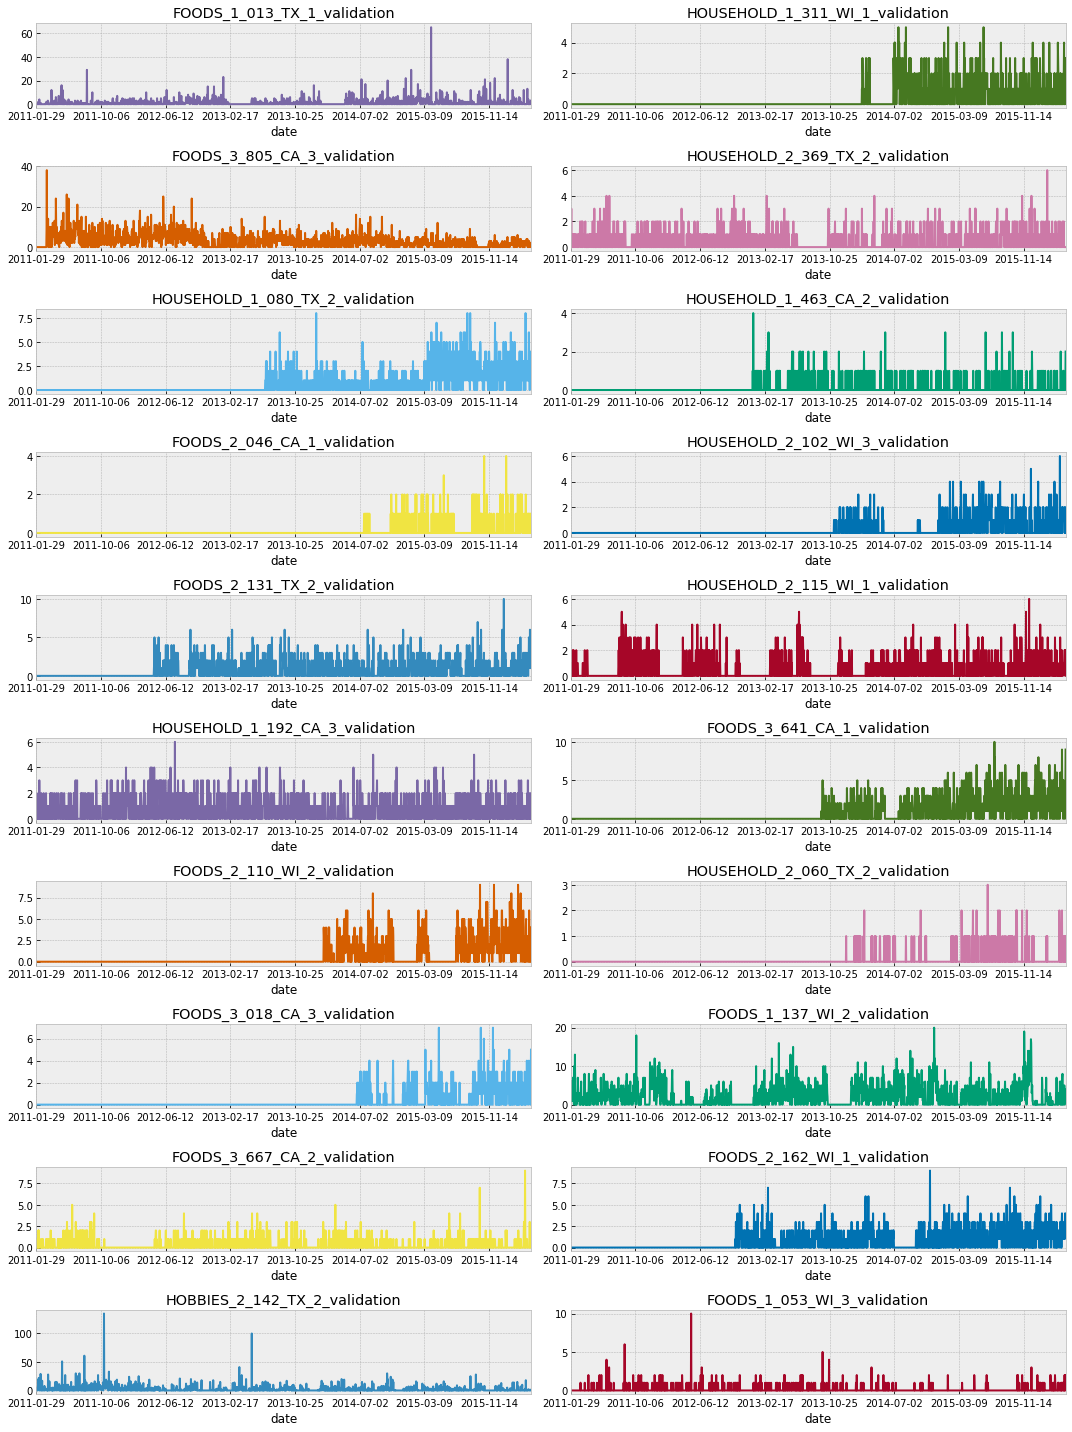

In [64]:
fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

# Combined Sales over Time by Type
- We have several item types:
    - Hobbies
    - Household
    - Foods
- Lets plot the total demand over time for each type

In [65]:
stv['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

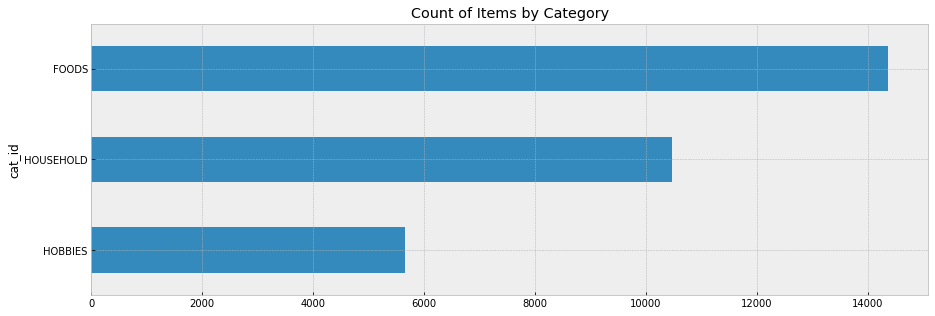

In [66]:
stv.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 5), title='Count of Items by Category')
plt.show()

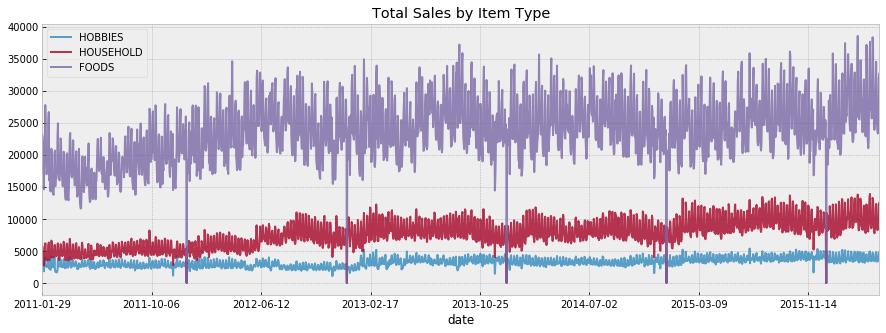

In [67]:
past_sales = stv.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')


for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Total Sales by Item Type')
plt.legend(stv['cat_id'].unique())
plt.show()

# Sales by Store
We are provided data for 10 unique stores. What are the total sales by stores?
- Note that some stores are more steady than others.
- CA_2 seems to have a big change occur in 2015

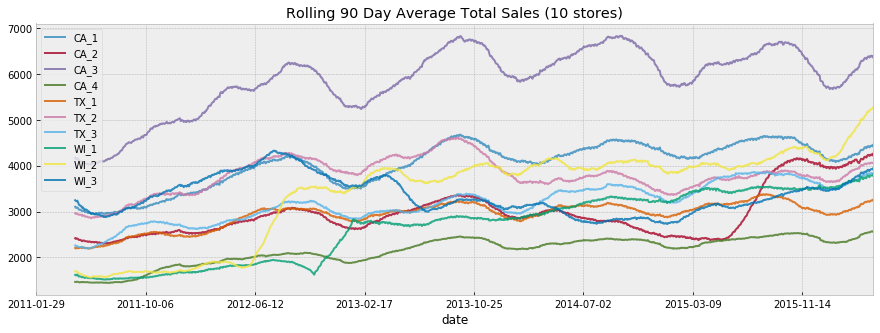

In [68]:
store_list = sellp['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

Looking at the same data a different way, we can plot a rolling 7 day total demand count by store. Note clearly that some stores have abrupt changes in their demand, it could be that the store expanded or a new competitor was built near by. Either way this is imporant to note when creating predictive models about demand pattern. 

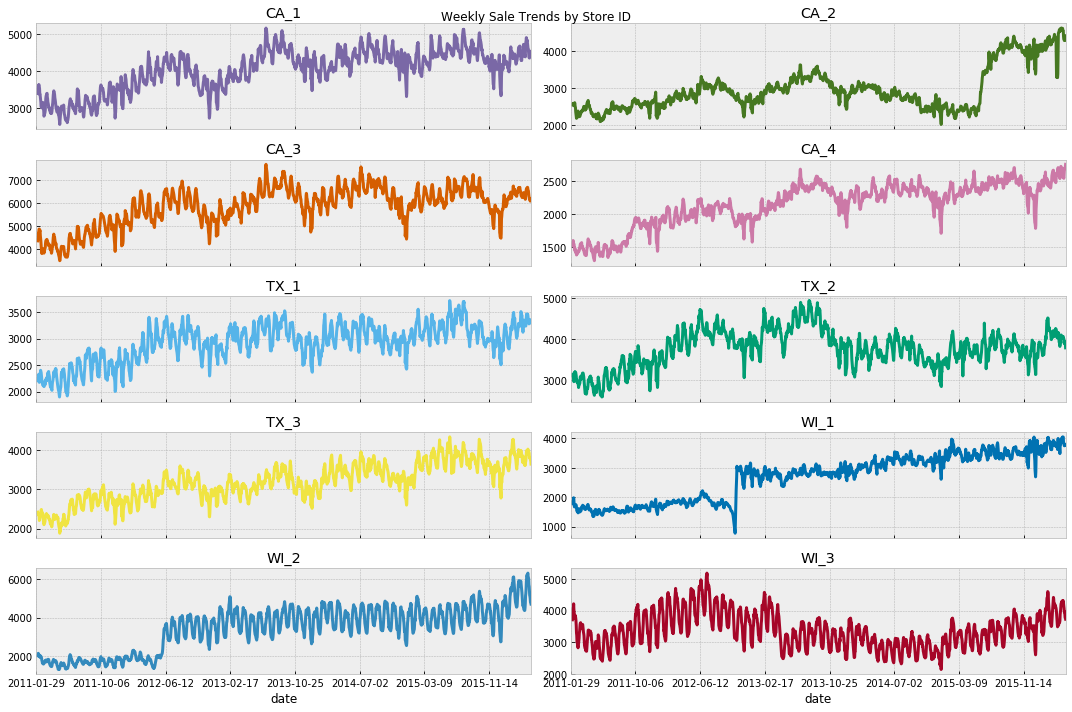

In [69]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(7).mean() \
        .plot(alpha=1,
              ax=axes[ax_idx],
              title=s,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1
# plt.legend(store_list)
plt.suptitle('Weekly Sale Trends by Store ID')
plt.tight_layout()
plt.show()

# A simple submission
- Submit the average value from the past 60 days

In [79]:
ss.head(1)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [80]:
day_avg_map = stv.set_index('id')[d_cols[-60:]].mean(axis=1).to_dict()
fcols = [f for f in ss.columns if 'F' in f]
for f in fcols:
    ss[f] = ss['id'].map(day_avg_map).fillna(0)
    
ss.to_csv('./submissions/submission_001.csv', index=False)